# Visualization of coordinates on a sample image

## Imports and declarations

In [50]:
import numpy as np
import torch
from torchvision.models import resnet50, ResNet50_Weights

from wings.config import COUNTRIES, RAW_DATA_DIR, PROCESSED_DATA_DIR
from wings.config import MODELS_DIR
from wings.dataset import WingsDataset
from wings.modeling.litnet import LitNet
from wings.modeling.models import ResnetPreTrained
from wings.visualizing.image_preprocess import denormalize
from wings.visualizing.image_preprocess import resize_preprocess
from wings.visualizing.visualize import visualize_coords
from wings.visualizing.visualize import visualize_from_file

In [51]:
resnet_dataset = torch.load(PROCESSED_DATA_DIR / "resize_datasets" / "test_dataset2.pth", weights_only=False)

### Komentarz
Po wprowadzeniu zmian w `WingsDataset` trzeba było wygenerować nowe bazy danych. Więc ogólnie z tego co mi się wydaje nie straciliśmy informacje o tym, na których zdjęciach było trenowane i walidowane. Raczej nie można policzyć z tego porządnych statystyk, ale przynajmniej można wyświetlić predykcje.

## Visualization raw image and coordinates from file

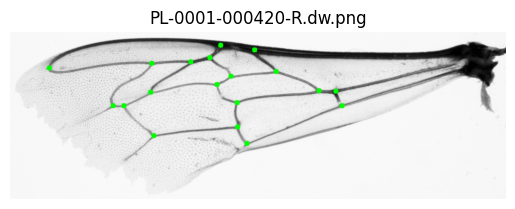

In [52]:
visualize_from_file(filename="PL-0001-000420-R.dw.png", spot_size=5)

## Visualize output from model

## RESNET model

In [53]:
# checkpoint_path = MODELS_DIR / 'resnet_pretrained_v02.ckpt'
checkpoint_path = MODELS_DIR / 'sample-resnet50-epoch=34-val_loss=196.32-nocrop4.ckpt'
weights = ResNet50_Weights.DEFAULT
resnet_model = ResnetPreTrained(resnet50, weights)

num_epochs = 15
model = LitNet.load_from_checkpoint(checkpoint_path, model=resnet_model, num_epochs=num_epochs, criterion=torch.nn.MSELoss)
model.eval()

max_n = len(resnet_dataset)
print(max_n)

2172


### Visualize

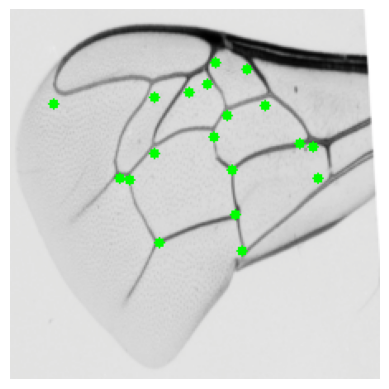

In [54]:
n = np.random.randint(0, max_n)
image, label = resnet_dataset[n]
labels = model(image.cuda().unsqueeze(0))
image = denormalize(image)
visualize_coords(image, labels.squeeze(0), spot_size=3)
